# Text classification pipeline using Deep Learning

<a target="_blank" href="https://colab.research.google.com/github/PacktPublishing/Mastering-NLP-from-Foundations-to-LLMs/blob/liors_branch/Chapter6_notebooks/Ch6_Text_Classification_DL.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

**Objective: Processing conclusions of medical publication and inferring whether the conclusion represents an advice or not.**
Based on Chapter 6, this notebook demonstrates a complete, end-to-end system design of a Deep Learning binary classifier.  
Given a text observation, the classifier with infer whether the content of the text is a medical advice or not.  

## The pipeline consists of:  
1. Code settings  
1. Gathering the data  
1. Processing the data
1. Prerocessing
1. Preliminary data exploration  
1. Feature engineering  
1. Exploring the new numerical features
1. Split to Train/Test
1. Preliminary statistical analysis and feasibility study
1. Feature selection
1. Machine Learning  
 11.1 Iterate over ML models  
 11.2 Generate the chosen model  
 11.3 Generating the train results  
 11.4 Generating the test results  
1. Deep Learning  
 12.1 Formatting our data  
 12.2 Training our LM  
    12.2.1 Training hyperparameters  
    12.2.2 Evaluation metric  
    12.2.3 Trainer object  
    12.2.4 Fine tuning  
    12.2.5 Conclusion about training length  
    12.2.6 Generating the train results   
    12.2.7 Generating the test results   

*Remark:  
This is a complete ML pipeline that is designed to be fully inclusive in a single notebook file. This is meant to be an instruction tool. In a professional dev environment, the design should be distributed across reproducible `.py` files for reproducibility and efficiency.  

## The Data:
A data set from [Hugging Face:
medical_meadow_health_advice](https://huggingface.co/datasets/medalpaca/medical_meadow_health_advice):   
>>
"This dataset holds thousands of text observation which are conclusion of medical publications. Each conclusion is annotated as to whether it represents an advice or not."  

**Requirements:**  
* When running in Colab, use this runtime notebook setting: `Python 3, T4 GPU`  

>*```Disclaimer: The content and ideas presented in this notebook are solely those of the authors and do not represent the views or intellectual property of the authors' employers.```*

Install:

In [1]:
# REMARK:
# If the below code error's out due to a Python package discrepency, it may be because new versions are causing it.
# In which case, set "default_installations" to False to revert to the original image:
default_installations = True
if default_installations:
    !pip -q install transformers datasets num2words autocorrect accelerate evaluate
else:
    import requests
    text_file_path = "text_classification.txt"
    url = "https://raw.githubusercontent.com/python-devops-sre/nlp/master/requirements/" + text_file_path           
    res = requests.get(url)
    with open(text_file_path, "w") as f:
      f.write(res.text)

    !pip install -r text_classification.txt

Imports:

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import scipy
import re
from datasets import load_dataset, Dataset

from num2words import num2words
import nltk; nltk.download('punkt'); nltk.download('stopwords'); nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from autocorrect import Speller

# ML imports:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
import sklearn.linear_model as lm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# DL imports:
from transformers import AutoTokenizer, TrainingArguments, Trainer
from torch.utils.data import DataLoader
import evaluate

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\laven\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\laven\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\laven\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Code Settings


In [3]:
# Items:
# source_of_dataset: Whether to load the dataset from the package, or from a URL (for the particular dataset in this notebook, both options are available)
# json_url: The url for the dataset's .json file
# db_name: The db name from HuggingFace that holds the raw data
# do_preprocessing: Logical, should preprocessing be performed
# do_enhanced_preprocessing: Logical, should the computation-heavy preprocessing be performed
# do_feature_eng: Logical
# maximize_a_priori: Logocal, should the univariate preliminary feature selection be based on a priori or a postiori stats
# num_chosen_features_per_class: Int, for the preliminary feature selection, how many features should be selected per class
# test_size: ratio between 0 - 1
# feature_eng_details: Either "TfidfVectorizer" (for TFIDF feature eng.) or "CountVectorizer" (for one hot encoding)
# seed: Integer, the random seed used to insure reproducibility of results
config_dict = {'source_of_dataset': "json",
               'json_url': "https://huggingface.co/datasets/medalpaca/medical_meadow_health_advice/raw/main/medical_meadow_health_advice.json",
               'db_name': "medalpaca/medical_meadow_health_advice",
               'do_preprocessing': True,
               'do_enhanced_preprocessing': False,
               'do_feature_eng': True,
               'maximize_a_priori': False,
               'num_chosen_features_per_class': 200,
               'test_size': 0.25,
               'feature_eng_details': "CountVectorizer-binary",
               'ngram_range_min': 1,
               'ngram_range_max': 3,
               'max_features': 1000,
               'seed': 0}

# Deep learning training parameters:
# See description of input parameters in documentation for transformers.TrainingArguments.
lm_training_args = TrainingArguments(
    output_dir="test_trainer",
    num_train_epochs=2,
    per_device_train_batch_size=8,
    learning_rate=2e-5,
    evaluation_strategy="steps",
    logging_steps=100,)

layers_to_fine_tune = None

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

### Gathering the Data

In [4]:
# Taking the dataset either via the datasets package or directly from a URL:
if config_dict["source_of_dataset"] == "datasets package":
  dataset_raw = load_dataset(config_dict["db_name"])
  dataset_df = pd.DataFrame(dataset_raw["train"])
elif config_dict["source_of_dataset"] == "json":
  # For this particualr dataset, the owners posted a .json file to accomodate the dataset:
  dataset_df = pd.read_json(config_dict["json_url"])

### Processing the Data


In [5]:
dataset_df["_label_"] = dataset_df["output"]
dataset_df["text"] = dataset_df["input"]
dataset_df = dataset_df[["text", "_label_"]]

Let's have a quick look at the raw data:  

In [6]:
dataset_df.head(4).style.set_properties(**{'text-align': 'left'})

,text,_label_
0,"As we have previously shown an additional effect of vibrating insoles on improving static balance [3–5], it is possible that the combined effect on balance and gait will have a greater impact on falls and mobility than our data would imply.",This is no advice
1,"Furthermore, gut microbiota analysis in mice treated with hypolipidemic drugs revealed a modification in composition in favor of probiotic-type bacteria from Lactobacillus spp. [49].",This is no advice
2,Further research is recommended that may be helpful in establishing the direction of the association.,This is no advice
3,Further study will be necessary to test if postnatal intervention can effectively promote neurodevelopmental outcomes for healthy infants with below-average white matter development at birth.,This is no advice


In [7]:
print("Distribution of original labels:\n")

dataset_df[["_label_"]].value_counts()

Distribution of original labels:



_label_                
This is no advice          6477
This is a weak advice      1338
This is a strong advice     861
Name: count, dtype: int64

While one could train a multi-class classification model that would diffrentiate between all 3 labels, we will reduce this to to being a binary classification problem.  
We are going to unite the two labels that indicate an advice so to have a binary decision: Whether a text represents and advice or not.  
So we are going to re-label:  
>>
Label 0: **Not** an advice    
Label 1: An advice

So now the classification problem is a binary classification problem.  

#### Picking the class to be targeted

In [8]:
dataset_df_binary = dataset_df.copy()
dataset_df_binary["_label_"] = dataset_df["_label_"].map({"This is no advice":0}).fillna(1).map(int)

In [9]:
print("Distribution of new labels:\n")
frequencies = dataset_df_binary[["_label_"]].value_counts()
frequencies

Distribution of new labels:



_label_
0          6477
1          2199
Name: count, dtype: int64

Recognizing the most frequent class.  
This establish a baseline accuracy (a prior) for this dataset:

In [10]:
most_frequent_class = frequencies.index[:][0][0]

print("The most frequent class is:", most_frequent_class)
print("And its baseline accuracy is:", round((dataset_df_binary["_label_"] == most_frequent_class).mean(), 3))

The most frequent class is: 0
And its baseline accuracy is: 0.747


### Preporcessing


Define the preprocessing utility functions:

In [11]:
def digits_to_words(match):
    """
    Convert string digits to the English words. The function distinguishes between
    cardinal and ordinal.
    E.g. "2" becomes "two", while "2nd" becomes "second"

    Input: str
    Output: str
    """
    suffixes = ['st', 'nd', 'rd', 'th']
    # Making sure it's lower cased so not to rely on previous possible actions:
    string = match[0].lower()
    if string[-2:] in suffixes:
        type='ordinal'      
        string = string[:-2]
    else:
        type='cardinal'
    return num2words(string, to=type)

def spelling_correction(text):
    """
    Replace misspelled words with the correct spelling.

    Input: str
    Output: str
    """
    corrector = Speller()
    spells = [corrector(word) for word in text.split()]
    return " ".join(spells)

def remove_stop_words(text):
    """
    Remove stopwords.

    Input: str
    Output: str
    """
    stopwords_set = set(stopwords.words('english'))
    return " ".join([word for word in text.split() if word not in stopwords_set])

def stemming(text):
    """
    Perform stemming of each word individually.

    Input: str
    Output: str
    """
    stemmer = PorterStemmer()
    return " ".join([stemmer.stem(word) for word in text.split()])

def lemmatizing(text):
    """
    Perform lemmatization for each word individually.

    Input: str
    Output: str
    """
    lemmatizer = WordNetLemmatizer()
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

def preprocessing(input_text):
    """
    This function represents a complete pipeline for text preprocessing.

    Input: str
    Output: str
    """
    output = input_text
    # Lower casing:
    output = output.lower()
    # Convert digits to words:
    # The following regex syntax looks for matching of consequtive digits tentatively followed by an ordinal suffix:
    output = re.sub(r'\d+(st)?(nd)?(rd)?(th)?', digits_to_words, output, flags=re.IGNORECASE)
    # Remove punctuations and other special characters:
    output = re.sub('[^ A-Za-z0-9]+', '', output)

    if config_dict["do_enhanced_preprocessing"]:
      # Spelling corrections:
      output = spelling_correction(output)

    # Remove stop words:
    output = remove_stop_words(output)

    if config_dict["do_enhanced_preprocessing"]:
      # Stemming:
      output = stemming(output)
      # Lemmatizing:
      output = lemmatizing(output)

    return output

Perform the preprocessing:

In [12]:
dataset_clean = dataset_df_binary.copy()

if config_dict["do_preprocessing"]:
    dataset_clean["text"] = [preprocessing(text) for text in dataset_clean["text"]]

In [13]:
dataset_clean[["text", "_label_"]].head(10).style.set_properties(**{'text-align': 'left'})

,text,_label_
0,previously shown additional effect vibrating insoles improving static balance threefive possible combined effect balance gait greater impact falls mobility data would imply,0
1,furthermore gut microbiota analysis mice treated hypolipidemic drugs revealed modification composition favor probiotictype bacteria lactobacillus spp fortynine,0
2,research recommended may helpful establishing direction association,0
3,study necessary test postnatal intervention effectively promote neurodevelopmental outcomes healthy infants belowaverage white matter development birth,0
4,hand rheumatoid factor epstein barr virus infections described cause falsely elevated c trachomatis igm titers ten eleven,0
5,interestingly within context proposed environmental enrichment may actually mild stressor mice moncek et al two thousand four,0
6,thus failed quit reduction attempt marker increased decreased interest changing,0
7,study replicates prior findings hughes et al two thousand eight cannabis users trying change make many often rapid transitions among use usual reduction abstinence states b reduction attempts common abstinence attempts c quit reduction attempts shortlived participants achieve longterm abstinence use alcohol illicit drugs significantly increase abstinence e seek treatment,0
8,use crosssectional design limits ascertainment direction association ie possible mindfulness strategies may change symptoms social anxiety disappear strengthened mindfulness strategies may offer advantages could plausibly reduce symptoms social anxiety,0
9,fact tumor metastasis increased lungs eselectinoverexpressing mice reduced eselectin knockout mice eighteen,0



## Preliminary data exploration
Every ML project should start with basic exploration of the data.  
The objectives are mainly to explore the nature of the data, and to study whether there is a connection between the "X" data (in our case, the input text) and the desired value, "Y" (in our case, classifying as advice).  

Here we start by looking at the most simple characteristic of the data: the length of each input.  
We will later explore the statistical dependence between the language used and the advice label.

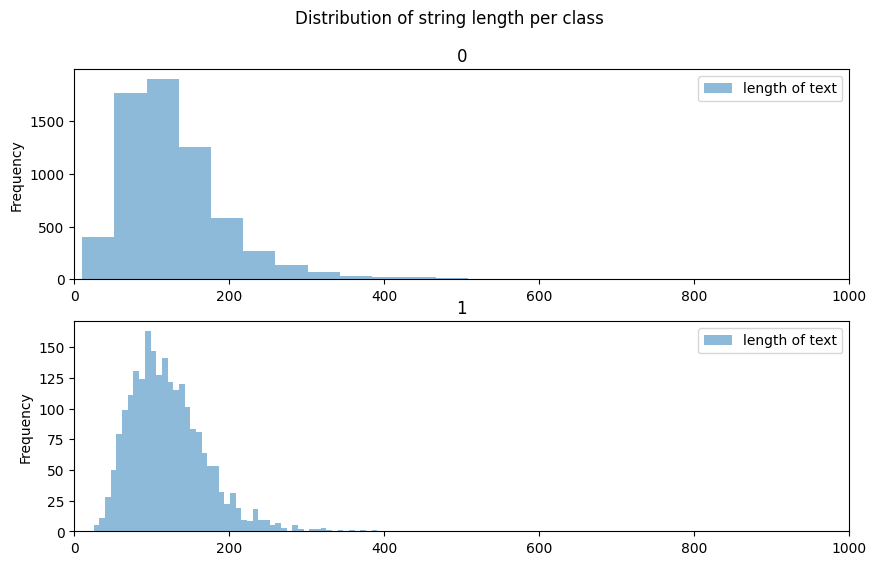

In [14]:
dataset_clean["length of text"] = dataset_clean["text"].map(len)
ax = dataset_clean.plot.hist(column=["length of text"], by="_label_", bins=50, alpha=0.5, figsize=(10, 6), title="Distribution of string length per class", xlim=[0, 1000])

## Feature engineering

In [15]:
def feat_eng_text_df(in_df, text_col, labels_col, config_dict):
  if "CountVectorizer-binary" == config_dict["feature_eng_details"]:
    print("Feature Engineering method: Binary (one hot encoding)")
    countvectorizer = CountVectorizer(ngram_range=(config_dict["ngram_range_min"], config_dict["ngram_range_max"]),
                                      stop_words='english',
                                      max_features=config_dict["max_features"],
                                      binary=True)

  elif "CountVectorizer-BOW" == config_dict["feature_eng_details"]:
    print("Feature Engineering method: Bag of words")
    countvectorizer = CountVectorizer(ngram_range=(config_dict["ngram_range_min"], config_dict["ngram_range_max"]),
                                      stop_words='english',
                                      max_features=config_dict["max_features"],
                                      binary=False)

  out_arr = countvectorizer.fit_transform(in_df[text_col])
  count_tokens = countvectorizer.get_feature_names_out()
  out_df = pd.DataFrame(data = out_arr.toarray(),columns = count_tokens)
  out_df[labels_col] = list(in_df[labels_col])
  return out_df


if config_dict["do_feature_eng"]:
  dataset_feat_eng = feat_eng_text_df(dataset_clean, 'text', '_label_', config_dict)
else:
  # This option isn't being supported, the notebook would fail. This option is
  # here to cater for a ML pipeline that uses deep learning language models that consume text, and not engineered features.
  dataset_feat_eng = dataset_clean.copy()

Feature Engineering method: Binary (one hot encoding)


## Exploring the new numerical features  

In [16]:
dataset_feat_eng.head()

,abdominal,ability,able,abnormal,abnormalities,absence,acceptable,access,according,account,...,wide,women,work,wound,year,years,young,younger,zeroone,_label_
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
dataset_feat_eng.describe().loc[['min', 'max', 'mean']]

,abdominal,ability,able,abnormal,abnormalities,absence,acceptable,access,according,account,...,wide,women,work,wound,year,years,young,younger,zeroone,_label_
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
mean,0.00438,0.004956,0.003688,0.003458,0.003804,0.003804,0.003804,0.004034,0.004841,0.006339,...,0.002766,0.026971,0.006224,0.002651,0.004034,0.017865,0.007492,0.003804,0.002997,0.253458


## Split to Train/Test

In [18]:
dataset_feat_eng_test = dataset_feat_eng.sample(frac=config_dict["test_size"],random_state=config_dict['seed'])
dataset_feat_eng_train = dataset_feat_eng.drop(dataset_feat_eng_test.index)

## Preliminary statistical analysis and feasibility study
This process is perhaps the most valuable for the preliminary study prior to applying ML.  
This is where we measure the relationship between "X" and "Y" so to see whether there is a "correlation".  

If this were a regression problem, where X and Y are numerical, then it would make sense to evaluate the correlation between X and Y, so to learn whether one could expect a linear regression model to yield good results.

Since neither X nor Y are numerical in their nature, we seek to evaluated the **statistical dependence** between them, so to know whether a model would have any "signal" to pick up on.  

Calc:  
**P(feature | class)**

In [19]:
## Statistics of features per class:
means_by_class = dataset_feat_eng_train.groupby(by=["_label_"]).mean().T.sort_index()
means_by_class.head()

_label_,0,1
abdominal,0.004954,0.002407
ability,0.004747,0.005415
able,0.004954,0.001805
abnormal,0.005160,0.000602
abnormalities,0.004334,0.001805


Calc the ratio that reflects statistical dependence:  
**P(class, feature)/(P(class)P(feature))**  
And note that it could be rewritten as:  
**P(class | feature)/P(class)**  
Or equivalently:  
**P(feature | class)/P(feature)**  

\*Note:  
The below calculation is assuming that the numerical features of each text term is **binary**, only then is the below a probability measure.  
If another feature method is used, such as BoW or TF/IDF, then the below is not the probability, but a proxy of it.  

In [20]:
P_class = sorted([[c, np.mean(dataset_feat_eng["_label_"] == c)] for c in set(means_by_class.columns)])
P_feature = sorted([[f, np.mean(dataset_feat_eng[f] > 0)] for f in dataset_feat_eng.columns if f != "_label_"])
P_feature_inv = [[f, 1/p] for f, p in P_feature]

P_class_arr = np.array(P_class)
P_feature_arr = np.array(P_feature)
P_feature_inv_arr = np.array(P_feature_inv)
# Multiplying a "column vector" of feature probablities with a "line vector" of
# class probilities to get a matrix where each element is a product of probabilities:
P_class_prod_P_feature_inv_arr = np.outer(P_feature_inv_arr[:, 1].astype(float), P_class_arr[:, 1].astype(float))

P_class_given_feature = means_by_class.copy()
for feature_counter in range(len(P_class_given_feature)):
  for c in P_class_given_feature.columns:
    # Right hand side: P(feature | class) / P(feature)
    P_class_given_feature.iloc[feature_counter][c] = means_by_class.iloc[feature_counter][c] / P_feature_arr[feature_counter, 1].astype(float)

**The terms that are most indicative of class "0":**

In [21]:
P_class_given_feature.sort_values([0], ascending=False).head(10)

_label_,0,1
associated lower,1.685376,0.000000
metaanalysis,1.652965,0.000000
thirteen,1.566873,0.093218
twentythree,1.566873,0.000000
citation,1.566873,0.000000
median,1.525421,0.000000
verbal,1.515218,0.000000
blood pressure,1.515218,0.000000
hivone,1.504198,0.417617
abnormal,1.492260,0.174007


**The terms that are most indicative of class "1":**

In [22]:
P_class_given_feature.sort_values([1], ascending=False).head(10)

_label_,0,1
promising,0.231060,4.041458
support use,0.061749,3.960164
option,0.030874,3.735155
alternative,0.096505,3.719795
tool,0.238762,3.712154
treatment option,0.000000,3.579577
treat,0.223839,3.480144
safe,0.344368,3.279367
findings support,0.503638,3.262635
suitable,0.447678,3.262635


## Feature selection
This is a univariate feature selection process.  
It is based on conditional dependency between a feature being 0/1 and a class being 0/1, thus the mean value of the feature is its probability.  
Note that the process of feature selection is done **on the training set**.   


For each class, choose the most indicative features.  
Either maximize the:   
* a-priori distribution P(feature | class), Max Liklihood  
or  
* a posteriori P(class | feature), MAP

In [23]:
chosen_features = []
if config_dict["maximize_a_priori"] == True:
  classes = means_by_class.columns
  for c in classes:
    chosen_features += list(means_by_class[c].sort_values(ascending=False).index[:config_dict["num_chosen_features_per_class"] + 1])
else:
  classes = P_class_given_feature.columns
  for c in classes:
    chosen_features += list(P_class_given_feature[c].sort_values(ascending=False).index[:config_dict["num_chosen_features_per_class"] + 1])

chosen_features = list(set(chosen_features))

In [24]:
chosen_features

['associated increased',
 'furthermore',
 'schizophrenia',
 'received',
 'rehabilitation',
 'analgesia',
 'tnf',
 'nctone million',
 'significance',
 'findings provide',
 'approximately',
 'comprehensive',
 'plasma',
 'avoid',
 'good',
 'younger',
 'doses',
 'future studies',
 'prevalence',
 'necessary',
 'reduced',
 'million',
 'twentyone',
 'support use',
 'choice',
 'types',
 'identifying',
 'maintain',
 'high risk',
 'settings',
 'mean',
 'selection',
 'original',
 'beliefs',
 'decreased',
 'provides',
 'included',
 'previously',
 'mental health',
 'enhance',
 'highrisk',
 'providing',
 'eighteen',
 'twentythree',
 'mass',
 'promising',
 'sample size',
 'considered',
 'prevention',
 'oxygen',
 'recent',
 'showed',
 'preliminary',
 'cardiovascular risk',
 'targeting',
 'intervention',
 'benefit',
 'important',
 'useful',
 'area',
 'adherence',
 'effective',
 'evidencebased',
 'needs',
 'higher',
 'recommended',
 'account',
 'occur',
 'active commuting',
 'thirtythree',
 'thousand',


### Leave only chosen features:
Now that we deduced which features are "important" based on the train set, we select them for both the train set and the test set.  

In [25]:
dataset_feat_eng_train_selected = dataset_feat_eng_train.filter(chosen_features + ["_label_"])
dataset_feat_eng_test_selected = dataset_feat_eng_test.filter(chosen_features + ["_label_"])

dataset_feat_eng_train_selected.head()

,associated increased,furthermore,schizophrenia,received,rehabilitation,analgesia,tnf,nctone million,significance,findings provide,...,thickness,significant difference,psychological,frequently,standard,variation,planning,highly,ninetyseven,_label_
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
dataset_feat_eng_train_selected["_label_"].value_counts()

_label_
0    4845
1    1662
Name: count, dtype: int64

# Machine Learning   


In [27]:
dataset_feat_eng_train_selected.head()

,associated increased,furthermore,schizophrenia,received,rehabilitation,analgesia,tnf,nctone million,significance,findings provide,...,thickness,significant difference,psychological,frequently,standard,variation,planning,highly,ninetyseven,_label_
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Parse out the Y labels from the dataset, and change the variable type to suit the models.

In [28]:
x_features_train = dataset_feat_eng_train_selected.values[:, 0:-1]
y_labels_train = dataset_feat_eng_train_selected.values[:, -1]

x_features_test = dataset_feat_eng_test_selected.values[:, :-1]
y_labels_test = dataset_feat_eng_test_selected.values[:, -1]

#### Iterate over ML models

In [29]:
models = []
models.append(("Random Forest", RandomForestClassifier(random_state=config_dict['seed'])))
models.append(("LASSO", lm.LogisticRegression(solver='liblinear', penalty='l1', max_iter=1000, random_state=config_dict['seed'])))
models.append(("KNN", KNeighborsClassifier()))
models.append(("Decision Tree", DecisionTreeClassifier(random_state=config_dict['seed'])))
models.append(("SVM", SVC(gamma='auto', random_state=config_dict['seed'])))

results = []
names = []
best_mean_result = 0
best_std_result = 0
for name, model in models:
    kfold = StratifiedKFold()
    cv_results = cross_val_score(model, X=x_features_train, y=y_labels_train, scoring='accuracy', cv=kfold)
    results.append(cv_results)
    names.append(name)
    print(name + ": mean(accuracy)=" + str(round(np.mean(cv_results), 3)) + ", std(accuracy)=" + str(round(np.std(cv_results), 3)))
    if (best_mean_result < np.mean(cv_results)) or ((best_mean_result == np.mean(cv_results)) and (best_std_result > np.std(cv_results))):
        best_mean_result = np.mean(cv_results)
        best_std_result = np.std(cv_results)
        best_model_name = name
        best_model = model

print("\nBest model is:\n" + best_model_name)

Random Forest: mean(accuracy)=0.817, std(accuracy)=0.012
LASSO: mean(accuracy)=0.845, std(accuracy)=0.017
KNN: mean(accuracy)=0.792, std(accuracy)=0.011
Decision Tree: mean(accuracy)=0.801, std(accuracy)=0.015
SVM: mean(accuracy)=0.746, std(accuracy)=0.001

Best model is:
LASSO


Observe the distribution of the results across the validation folds:

C:\Users\laven\AppData\Local\Temp\ipykernel_5072\2224076768.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  matplotlib.pyplot.boxplot(results, labels=names)


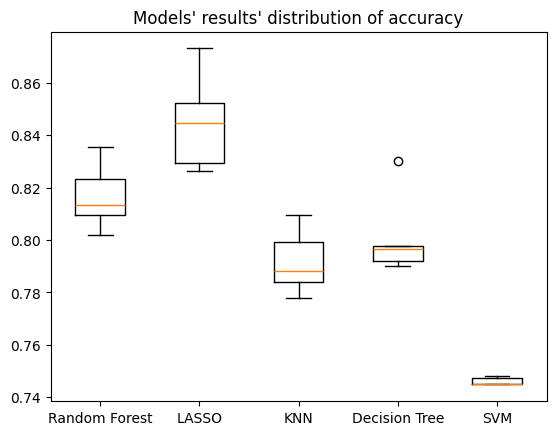

In [30]:
matplotlib.pyplot.boxplot(results, labels=names)
matplotlib.pyplot.title("Models' results' distribution of accuracy")
matplotlib.pyplot.show()

### Generate the chosen model

Optimize the hyperparameters:

In [31]:
model = lm.LogisticRegression(solver='liblinear', penalty='l1', max_iter=1000, random_state=config_dict['seed'])
params = {"C": np.linspace(start=0.001, stop=10, num=20)}
grid_search = GridSearchCV(model, params, scoring='accuracy')
grid_search.fit(x_features_train, y_labels_train)

print("The optimal hyperparameter 'C' is:", grid_search.best_params_["C"])

The optimal hyperparameter 'C' is: 2.1060526315789474


Fit the optimized model to the training set:

In [32]:
model = lm.LogisticRegression(C=grid_search.best_params_["C"], max_iter=1000, random_state=config_dict['seed'])
model.fit(x_features_train, y_labels_train)

LogisticRegression(C=2.1060526315789474, max_iter=1000, random_state=0)

### Generate the ML train results: Use for Design Choices

In [33]:
y_train_estimated = model.predict(x_features_train)
accuracy_train = np.mean(y_train_estimated == y_labels_train)
baseline_accuracy_train = np.mean(0 == y_labels_train)
accuracy_lift_train = 100 * (accuracy_train/baseline_accuracy_train - 1)

print("Results on the train set for a traditional ML model:\n-------------------------")
print("Baseline (dummy classifier) accuracy:", round(baseline_accuracy_train, 2))
print("Current model's accuracy:", round(accuracy_train, 2))
print("The accuracy lift is:", round(accuracy_lift_train), "%")

Results on the train set for a traditional ML model:
-------------------------
Baseline (dummy classifier) accuracy: 0.74
Current model's accuracy: 0.88
The accuracy lift is: 18 %


### Generate the ML test results: Use for presenting performance

In [34]:
y_test_estimated = model.predict(x_features_test)
accuracy_test = np.mean(y_test_estimated == y_labels_test)
baseline_accuracy_test = np.mean(0 == y_labels_test)
accuracy_lift = 100 * (accuracy_test/baseline_accuracy_test - 1)

print("Results on the test set for a traditional ML model:\n-------------------------")
print("Baseline (dummy classifier) accuracy:", round(baseline_accuracy_test, 2))
print("Current model's accuracy:", round(accuracy_test, 2))
print("The accuracy lift is:", round(accuracy_lift), "%")

print("\nConfusion Matrix:")
print(confusion_matrix(y_labels_test, y_test_estimated))
print("\nClassification Report:")
print(classification_report(y_labels_test, y_test_estimated))

Results on the test set for a traditional ML model:
-------------------------
Baseline (dummy classifier) accuracy: 0.75
Current model's accuracy: 0.85
The accuracy lift is: 13 %

Confusion Matrix:
[[1504  128]
 [ 196  341]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1632
           1       0.73      0.64      0.68       537

    accuracy                           0.85      2169
   macro avg       0.81      0.78      0.79      2169
weighted avg       0.85      0.85      0.85      2169



****
# Deep Learning  
Applying BERT, a Language Model to Text Classification

## Formatting our data
Adjusting the name of the label column:  
The design of the Transformers package requires the dataset's lables column to be named exactly `label`.  
In the above part of this notebook, where we did tranditional ML work, we had to pick a column name that **isn't** a natural word. The reason is that when we performed feature engineering, each word/Ngram was allocated its own column named after it. If the word "label" just happened to appear in the text, it could have a column called `label` defined for it in the dataframe, which would then **conflict with the labels' column name**.  
We no longer have that risk, and we need to comply with Transformers' requirements:  

In [35]:
df = dataset_df_binary.copy()
dataset_df_binary = dataset_df_binary.rename(columns={"_label_":"label"})

Load the tokenizer and the pre-trained Language Model:

In [36]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

labels = list(dataset_df_binary["label"].unique())

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
language_model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(labels))

f:\python\transformers\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


>>
The previous cell would output a warnin starting with:  
`Some weights of the model checkpoint at bert-base-uncased were not used when initializing...`

>>
It is expected, as the model you imported had its pre-trained classification head (i.e. last neural layer) removed and a new "fresh" layer is initialized.  
That's what we want, as we seek to train that classification head to suit our dataset. Based on our choice, we may choose to also fine-tune other layers.    

In [37]:
print(f"The size of the model's token dictionary: {language_model.config.vocab_size}")

The size of the model's token dictionary: 30522


Split the dataset to three sub-sets:  
1. A held-out test set  
2. A train set that is split to two:  
  2.1 A subset used for training the neural network's parameters  
  2.2 A subset used to evaluate the progress of the training  

In [38]:
# Create a training set and a test set
test_df = dataset_df_binary.sample(frac=config_dict["test_size"],random_state=config_dict['seed'])
train_df = dataset_df_binary.drop(test_df.index)

# Splitting the train set to "just train" and "training evaluation" set:
train_eval_df = train_df.sample(frac=config_dict["test_size"],random_state=config_dict['seed'])
train_train_df = train_df.drop(train_eval_df.index)

# Conver the dataframes to a Dataset format per the Transformers package's requirement:
dataset_train_train = Dataset.from_pandas(train_train_df)
dataset_train_eval = Dataset.from_pandas(train_eval_df)
dataset_test = Dataset.from_pandas(test_df)

In order for the LM to process the text, it must be tokenized:

In [39]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

train_train_tokenized = dataset_train_train.map(tokenize_function, batched=True)
train_eval_tokenized = dataset_train_eval.map(tokenize_function, batched=True)
test_tokenized = dataset_test.map(tokenize_function, batched=True)

Map:   0%|          | 0/4880 [00:00<?, ? examples/s]

Map:   0%|          | 0/1627 [00:00<?, ? examples/s]

Map:   0%|          | 0/2169 [00:00<?, ? examples/s]

<a id='trainer'></a>

## Training our LM

We fine tune our pre-trained Language Model via `transformers`'s [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer).  

### Choosing which neural network layers to fine-tune

In [40]:
if layers_to_fine_tune == "head":
  print("Fine-tuning only the classification head!")
  language_model.train()
  for name, param in language_model.named_parameters():
    # Freeze parameters of all layers except classifier head:
    if 'classifier' not in name:
        param.requires_grad = False
else:
  print("Fine-tuning the entire neural network!")

Fine-tuning the entire neural network!


### Training hyperparameters

These are the settings for training our model:

### Evaluation metric

Defining the evaluation metric for the Language Model fine-tuning:

In [41]:
metric = evaluate.load("accuracy")

Setting the metric evaluation function for the trainer to utilize:

In [42]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # As the model returns a pair of logit values for each observation,
    # where each of the two logit value reflects the likelihood of each
    # class, we want to conver it to a classification:
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

### Trainer object

In [43]:
trainer = Trainer(
    model=language_model,
    args=lm_training_args,
    train_dataset=train_train_tokenized,
    eval_dataset=train_eval_tokenized,
    compute_metrics=compute_metrics,
)

f:\python\transformers\Lib\site-packages\accelerate\accelerator.py:444: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


### Fine tuning

In [44]:
trainer.train()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: howsenpl (howsen). Use `wandb login --relogin` to force relogin


  0%|          | 0/1220 [00:00<?, ?it/s]

{'loss': 0.38, 'grad_norm': 2.9783761501312256, 'learning_rate': 1.836065573770492e-05, 'epoch': 0.16}


  0%|          | 0/204 [00:00<?, ?it/s]

{'eval_loss': 0.27474066615104675, 'eval_accuracy': 0.8881376767055931, 'eval_runtime': 33.8185, 'eval_samples_per_second': 48.11, 'eval_steps_per_second': 6.032, 'epoch': 0.16}
{'loss': 0.2702, 'grad_norm': 3.9377524852752686, 'learning_rate': 1.6721311475409837e-05, 'epoch': 0.33}


  0%|          | 0/204 [00:00<?, ?it/s]

{'eval_loss': 0.27000442147254944, 'eval_accuracy': 0.9121081745543946, 'eval_runtime': 34.0136, 'eval_samples_per_second': 47.834, 'eval_steps_per_second': 5.998, 'epoch': 0.33}
{'loss': 0.2652, 'grad_norm': 33.225318908691406, 'learning_rate': 1.5081967213114754e-05, 'epoch': 0.49}


  0%|          | 0/204 [00:00<?, ?it/s]

{'eval_loss': 0.24206854403018951, 'eval_accuracy': 0.9225568531038721, 'eval_runtime': 33.3211, 'eval_samples_per_second': 48.828, 'eval_steps_per_second': 6.122, 'epoch': 0.49}
{'loss': 0.2296, 'grad_norm': 2.081664562225342, 'learning_rate': 1.3442622950819673e-05, 'epoch': 0.66}


  0%|          | 0/204 [00:00<?, ?it/s]

{'eval_loss': 0.44861501455307007, 'eval_accuracy': 0.8838352796558082, 'eval_runtime': 33.3356, 'eval_samples_per_second': 48.807, 'eval_steps_per_second': 6.12, 'epoch': 0.66}
{'loss': 0.2537, 'grad_norm': 0.10515588521957397, 'learning_rate': 1.1803278688524591e-05, 'epoch': 0.82}


  0%|          | 0/204 [00:00<?, ?it/s]

{'eval_loss': 0.24072228372097015, 'eval_accuracy': 0.9354640442532268, 'eval_runtime': 33.3203, 'eval_samples_per_second': 48.829, 'eval_steps_per_second': 6.122, 'epoch': 0.82}
{'loss': 0.2077, 'grad_norm': 26.436975479125977, 'learning_rate': 1.0163934426229509e-05, 'epoch': 0.98}


  0%|          | 0/204 [00:00<?, ?it/s]

{'eval_loss': 0.21852120757102966, 'eval_accuracy': 0.931161647203442, 'eval_runtime': 33.2929, 'eval_samples_per_second': 48.869, 'eval_steps_per_second': 6.127, 'epoch': 0.98}
{'loss': 0.1221, 'grad_norm': 20.003679275512695, 'learning_rate': 8.524590163934427e-06, 'epoch': 1.15}


  0%|          | 0/204 [00:00<?, ?it/s]

{'eval_loss': 0.26400530338287354, 'eval_accuracy': 0.9391518131530424, 'eval_runtime': 33.3358, 'eval_samples_per_second': 48.806, 'eval_steps_per_second': 6.12, 'epoch': 1.15}
{'loss': 0.0855, 'grad_norm': 1.1496514081954956, 'learning_rate': 6.885245901639345e-06, 'epoch': 1.31}


  0%|          | 0/204 [00:00<?, ?it/s]

{'eval_loss': 0.2907136082649231, 'eval_accuracy': 0.9373079287031346, 'eval_runtime': 33.3578, 'eval_samples_per_second': 48.774, 'eval_steps_per_second': 6.116, 'epoch': 1.31}
{'loss': 0.1209, 'grad_norm': 8.702261924743652, 'learning_rate': 5.245901639344263e-06, 'epoch': 1.48}


  0%|          | 0/204 [00:00<?, ?it/s]

{'eval_loss': 0.2782484292984009, 'eval_accuracy': 0.9373079287031346, 'eval_runtime': 33.2978, 'eval_samples_per_second': 48.862, 'eval_steps_per_second': 6.127, 'epoch': 1.48}
{'loss': 0.13, 'grad_norm': 0.0804160088300705, 'learning_rate': 3.6065573770491806e-06, 'epoch': 1.64}


  0%|          | 0/204 [00:00<?, ?it/s]

{'eval_loss': 0.2787436544895172, 'eval_accuracy': 0.9416103257529195, 'eval_runtime': 33.3168, 'eval_samples_per_second': 48.834, 'eval_steps_per_second': 6.123, 'epoch': 1.64}
{'loss': 0.1405, 'grad_norm': 0.4325740933418274, 'learning_rate': 1.9672131147540985e-06, 'epoch': 1.8}


  0%|          | 0/204 [00:00<?, ?it/s]

{'eval_loss': 0.26298484206199646, 'eval_accuracy': 0.9391518131530424, 'eval_runtime': 33.3419, 'eval_samples_per_second': 48.797, 'eval_steps_per_second': 6.118, 'epoch': 1.8}
{'loss': 0.1609, 'grad_norm': 0.2510626018047333, 'learning_rate': 3.278688524590164e-07, 'epoch': 1.97}


  0%|          | 0/204 [00:00<?, ?it/s]

{'eval_loss': 0.25618091225624084, 'eval_accuracy': 0.9409956976029502, 'eval_runtime': 33.5613, 'eval_samples_per_second': 48.479, 'eval_steps_per_second': 6.078, 'epoch': 1.97}
{'train_runtime': 977.7521, 'train_samples_per_second': 9.982, 'train_steps_per_second': 1.248, 'train_loss': 0.1958702054180083, 'epoch': 2.0}


TrainOutput(global_step=1220, training_loss=0.1958702054180083, metrics={'train_runtime': 977.7521, 'train_samples_per_second': 9.982, 'train_steps_per_second': 1.248, 'train_loss': 0.1958702054180083, 'epoch': 2.0})

Converting the training log to a dataframe for plotting:

In [45]:
training_logs_df = pd.DataFrame(trainer.state.log_history).groupby("step", as_index=False).first()

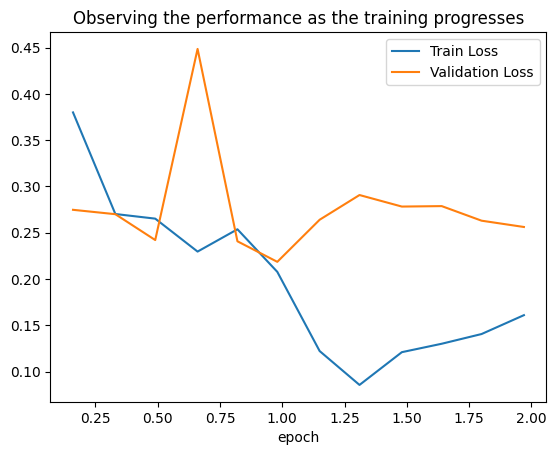

In [46]:
import matplotlib.pyplot as plt

training_logs_df.plot(x="epoch", y=["loss", "eval_loss"])
plt.title('Observing the performance as the training progresses')
plt.legend(['Train Loss', 'Validation Loss'], loc='upper right')
plt.show()

For reference,  
Here are the curves for when running with 5 epoches:  
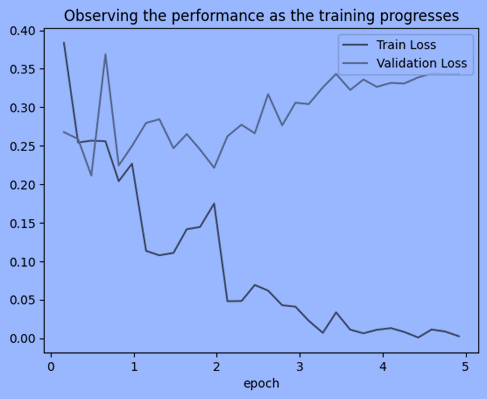

### Conclusion about training length
As can be seen, the evaluation set's results show that cutting the training time by half, using a single epoch instead of two, would be better.  
We chose two epoch so to let you witness that. It appears that after the first epoch the model starts to overfit the training set, thus becoming less accurate and less valuable.   
We would suggest examining the results with more than two epochs as well.  

### Generate the DL train results: Use for Design Choices

In [47]:
results_train_train = trainer.predict(train_train_tokenized)#
predictions_train_train = np.argmax(results_train_train[0], axis=-1)

accuracy_dl_train = np.mean(predictions_train_train == train_train_df["label"])
baseline_accuracy_dl_train = np.mean(most_frequent_class == train_train_df["label"])
accuracy_dl_lift_train = 100 * (accuracy_dl_train/baseline_accuracy_dl_train - 1)

print("Results on the train set for a DL Language Model:\n----------------------------------------------------")
print("Baseline (dummy classifier) accuracy:", round(baseline_accuracy_dl_train, 2))
print("Current model's accuracy:", round(accuracy_dl_train, 2))
print("The accuracy lift is:", round(accuracy_dl_lift_train), "%")

  0%|          | 0/610 [00:00<?, ?it/s]

Results on the train set for a DL Language Model:
----------------------------------------------------
Baseline (dummy classifier) accuracy: 0.74
Current model's accuracy: 0.98
The accuracy lift is: 32 %


### Generate the DL test results: Use for presenting performance

In [48]:
results_test = trainer.predict(test_tokenized)
predictions_test = np.argmax(results_test[0], axis=-1)

accuracy_dl_test = np.mean(predictions_test == test_df["label"])
baseline_accuracy_dl_test = np.mean(most_frequent_class == test_df["label"])
accuracy_dl_lift = 100 * (accuracy_dl_test/baseline_accuracy_dl_test - 1)

print("Results on the test set for a DL Language Model:\n---------------------------------------------------")
print("Baseline (dummy classifier) accuracy:", round(baseline_accuracy_dl_test, 2))
print("Current model's accuracy:", round(accuracy_dl_test, 2))
print("The accuracy lift is:", round(accuracy_dl_lift), "%")


print("\nConfusion Matrix:")
print(confusion_matrix(test_df["label"], predictions_test))
print("\nClassification Report:")
print(classification_report(test_df["label"], predictions_test))

  0%|          | 0/272 [00:00<?, ?it/s]

Results on the test set for a DL Language Model:
---------------------------------------------------
Baseline (dummy classifier) accuracy: 0.75
Current model's accuracy: 0.95
The accuracy lift is: 26 %

Confusion Matrix:
[[1563   69]
 [  46  491]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1632
           1       0.88      0.91      0.90       537

    accuracy                           0.95      2169
   macro avg       0.92      0.94      0.93      2169
weighted avg       0.95      0.95      0.95      2169



<a id='pytorch_native'></a>